In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Reweighting

**hep_ml.reweight** contains methods to reweight distributions: `BinsReweighter`, `GBReweighter`

**hep_ml.metrics_utils** contains `ks_2samp_weighted`. Use it to compute KS metric

In [2]:
from hep_ml import reweight
import root_numpy
import pandas
from hep_ml.metrics_utils import ks_2samp_weighted, _cvm_2samp_fast

/Users/antares/.virtualenvs/test/lib/python2.7/site-packages/hep_ml/reweight.py:49: UserWarning: Module hep_ml.reweight is unstable, it's API may be changed in near future.
  warn("Module hep_ml.reweight is unstable, it's API may be changed in near future.")


## Downloading data

In [3]:
storage = 'https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/'
!wget -O datasets/MC_distribution.root -nc $storage/MC_distribution.root?raw=true
!wget -O datasets/RD_distribution.root -nc $storage/RD_distribution.root?raw=true

File `datasets/MC_distribution.root' already there; not retrieving.
File `datasets/RD_distribution.root' already there; not retrieving.


## Read data

Pay attention that here we work with `.root` files and `root_numpy` can help

In [4]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b']

original = root_numpy.root2array('datasets/MC_distribution.root', branches=columns)
target = root_numpy.root2array('datasets/RD_distribution.root', branches=columns)

original = pandas.DataFrame(original)
target = pandas.DataFrame(target)

original_weights = numpy.ones(len(original))

## Original distributions

In [5]:
hist_kw = {'bins': 100, 'normed': True, 'alpha': 0.5}

def plot_pdf(features, new_original_weights, weights_target=None, label=''):
    figsize(14, 8)
    if weights_target is None:
        weights_target = numpy.ones(len(target), dtype=float)
    for index, column in enumerate(features, 1):
        xlim = numpy.percentile(target[column], [0.01, 99.99])
        subplot(2, 2, index)
        hist(original[column].values, weights=new_original_weights, range=xlim, 
             label=label + 'original(MC)', **hist_kw)
        hist(target[column].values, range=xlim, label='target(real)', **hist_kw)
        title(column)
        legend()
        print column, 'KS:', ks_2samp_weighted(original[column], target[column], 
                                               weights1=new_original_weights, 
                                               weights2=weights_target)        

hSPD KS: 0.520354072828
pt_b KS: 0.2163936444
pt_phi KS: 0.402011359241
vchi2_b KS: 0.404663850873


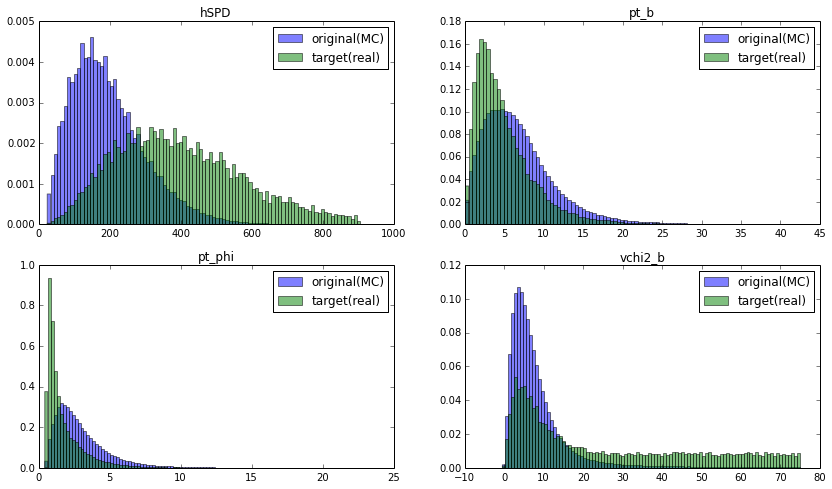

In [6]:
plot_pdf(columns, original_weights)

## Compare 1D reweighting: Bin, GB. 

* Choose one variable for reweighting
* Use KS metric to compare which method is the best.
* Do other variables after 1D reweigthig agree? What does it mean?

### Bin reweighting

hSPD KS: 0.0136003727001
pt_b KS: 0.233165453697
pt_phi KS: 0.398857147652
vchi2_b KS: 0.372881065827


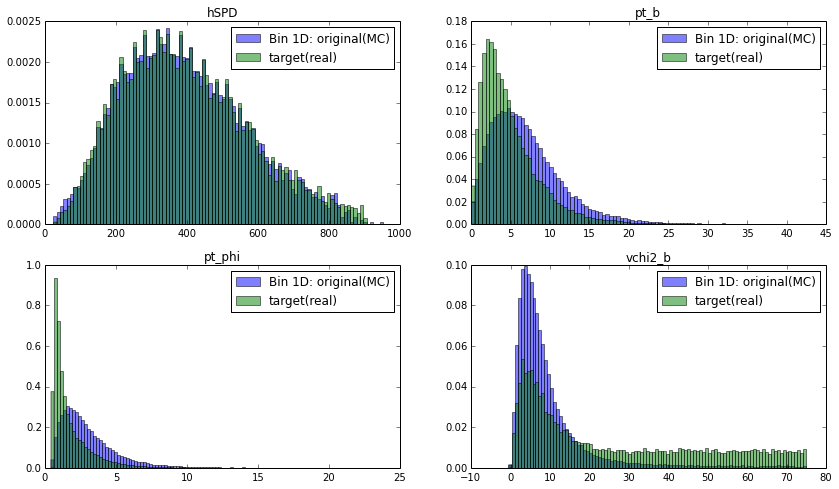

In [7]:
variable_1d = 'hSPD'
bins_reweighter = reweight.BinsReweighter(n_bins=50, n_neighs=1.)
bins_reweighter.fit(original[variable_1d], target[variable_1d])

bins_weights = bins_reweighter.predict_weights(original[variable_1d])
plot_pdf(columns, bins_weights, label='Bin 1D: ')

As you see for some of other variables KS metric became a bit worse, for some - a bit better. The Difference is inessential.

**TODO**

* Compute CvM between chosen feature and others. Are they correlated?

In [8]:
from utils import compute_cvm
for index in range(4):
    print columns[index], compute_cvm(target[variable_1d], target[columns[index]])
print 'random', compute_cvm(target[variable_1d], numpy.random.random(size=len(target)))

hSPD 0.163559992683
pt_b 0.00182136681827
pt_phi 0.00386326600096
vchi2_b 0.00735061159431
random 0.000752835954717


For a random variable the correlation is 10 times less than for features thus all features are correlated indeed.

### GB reweighting

This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality.
It uses decision trees and special loss functiion (**ReweightLossFunction**).

**GBReweighter** supports negative weights (to reweight MC to splotted real data).

hSPD KS: 0.00848149502648
pt_b KS: 0.2330938103
pt_phi KS: 0.39875382636
vchi2_b KS: 0.37299704568


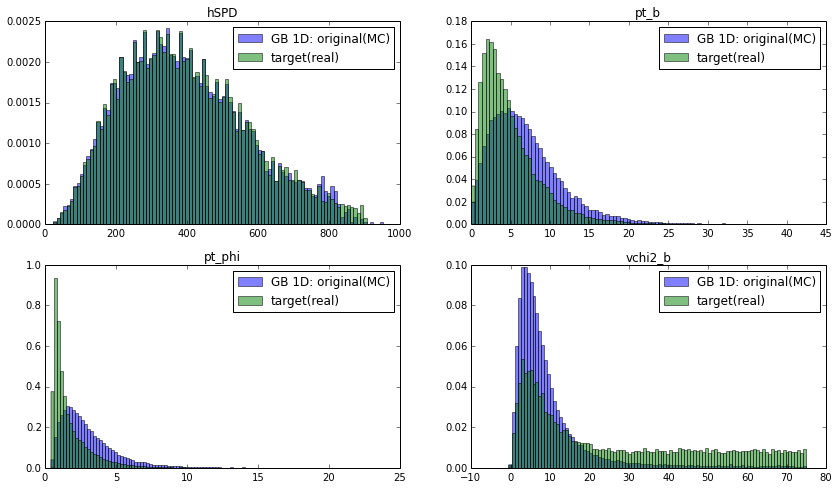

In [9]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=4, min_samples_leaf=500, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(original[variable_1d], target[variable_1d])

gb_weights = reweighter.predict_weights(original[variable_1d])
plot_pdf(columns, gb_weights, label='GB 1D: ')

## Compare ND reweighting: Bin, GB. 

Use ML to compare which method is the best. Does it really work?

### Bin ND reweighter

hSPD KS: 0.207089616076
pt_b KS: 0.0711331226549
pt_phi KS: 0.0726429341738
vchi2_b KS: 0.143250560328


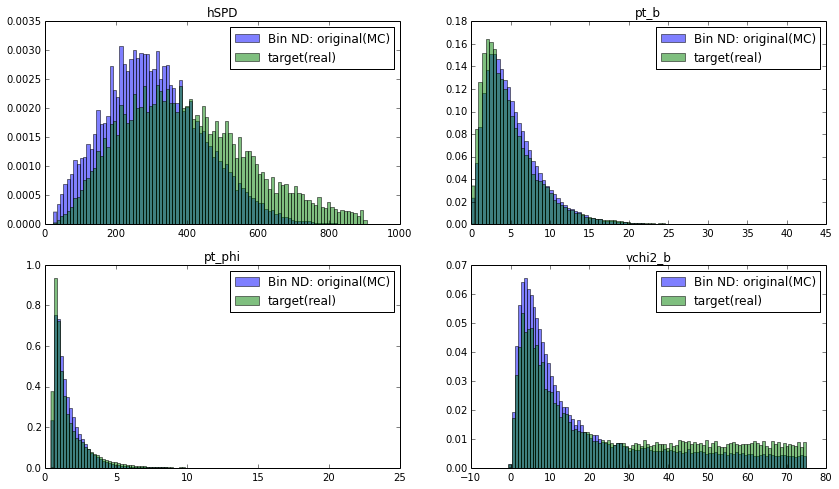

In [10]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original, target)

bins_weights = bins_reweighter.predict_weights(original)
plot_pdf(columns, bins_weights, label='Bin ND: ')

### GB ND reweighter

hSPD KS: 0.0321259161671
pt_b KS: 0.028377807477
pt_phi KS: 0.0252181448024
vchi2_b KS: 0.0283670110166


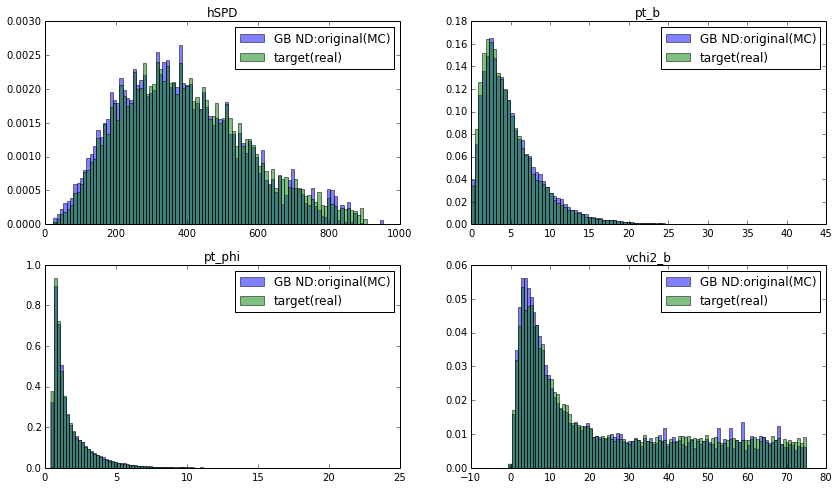

In [11]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=500, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(original, target)

gb_weights = reweighter.predict_weights(original)
plot_pdf(columns, gb_weights, label='GB ND:')

## GB-discrimination
let's check how well the classifier is able to distinguish these distributions. ROC AUC is taken as measure of quality.

For this puprose we split data into train and test, then train a classifier to distinguish these distributions.
If ROC AUC = 0.5 on test, distibutions are equal, if ROC AUC = 1.0, they are ideally separable.

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

data = numpy.concatenate([original, target])
labels = numpy.array([0] * len(original) + [1] * len(target))

weights = {}
weights['original'] = original_weights
weights['bins'] = bins_weights
weights['gb_weights'] = gb_weights


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.5, max_depth=8, learning_rate=0.05,
                                     n_estimators=100).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)

original 0.885156669177
bins 0.760809892516
gb_weights 0.545403722923


Thus GB reweighter is better because its AUC is close to 0.5. And it strongly improves original pdf while Bin reweighter improves a little bit.

## Comparing some simple expressions:
The most interesting is checking some other variables in multidimensional distributions (those are expressed via original variables).

* Compute different expressions. For them compute KS.
* Make the `hist2d` plots for one combination of features vs another combination of features

**Hint**:
`hist2d(original.eval(expression1).values, original.eval(expression2).values, 
        bins=100, normed=True)`

In [13]:
def check_ks_of_expression(expression):
    col_original = original.eval(expression, engine='python')
    col_target = target.eval(expression, engine='python')
    w_target = numpy.ones(len(col_target), dtype='float')
    print 'No reweight   KS:', ks_2samp_weighted(col_original, col_target, weights1=original_weights, weights2=w_target)        
    print 'Bins reweight KS:', ks_2samp_weighted(col_original, col_target, weights1=bins_weights, weights2=w_target)
    print 'GB Reweight   KS:', ks_2samp_weighted(col_original, col_target, weights1=gb_weights, weights2=w_target)

### Check KS for simple expressions

In [14]:
check_ks_of_expression('hSPD')

No reweight   KS: 0.520354072828
Bins reweight KS: 0.207089616076
GB Reweight   KS: 0.0321259161671


In [15]:
check_ks_of_expression('hSPD * pt_phi')

No reweight   KS: 0.0893469908354
Bins reweight KS: 0.128324034056
GB Reweight   KS: 0.013448907816


In [16]:
check_ks_of_expression('hSPD * pt_phi * vchi2_b')

No reweight   KS: 0.369074009072
Bins reweight KS: 0.187406644277
GB Reweight   KS: 0.0256749309353


In [17]:
check_ks_of_expression('pt_b * pt_phi / hSPD ')

No reweight   KS: 0.478065348794
Bins reweight KS: 0.201447463888
GB Reweight   KS: 0.0468429295206


In [18]:
check_ks_of_expression('hSPD * pt_b * vchi2_b / pt_phi')

No reweight   KS: 0.49379287783
Bins reweight KS: 0.169971624663
GB Reweight   KS: 0.0281516715382


### Hist2d plots 

In [19]:
def hist2d_expressions(f1, f2, vmax):
    figsize(15, 12)
    
    subplot(2, 2, 1)
    hist2d(target.eval(f1).values, target.eval(f2).values, 
           bins=100, normed=True)
    clim(0, vmax)
    title('target: {} vs {}'.format(f1, f2), color='y')
    
    subplot(2, 2, 2)
    hist2d(original.eval(f1).values, original.eval(f2).values, 
           bins=100, normed=True)
    clim(0, vmax)
    title('original: {} vs {}'.format(f1, f2), color='y')
    xlim(min(target.eval(f1).values), max(target.eval(f1).values))
    ylim(min(target.eval(f2).values), max(target.eval(f2).values))
    
    subplot(2, 2, 4)
    hist2d(original.eval(f1).values, original.eval(f2).values, 
           bins=100, normed=True, 
           weights=bins_weights)
    clim(0, vmax)
    title('Bin RW: {} vs {}'.format(f1, f2), color='y')
    xlim(min(target.eval(f1).values), max(target.eval(f1).values))
    ylim(min(target.eval(f2).values), max(target.eval(f2).values))
    
    subplot(2, 2, 3)
    hist2d(original.eval(f1).values, original.eval(f2).values, 
           bins=100, normed=True, 
           weights=gb_weights)
    clim(0, vmax)
    xlim(min(target.eval(f1).values), max(target.eval(f1).values))
    ylim(min(target.eval(f2).values), max(target.eval(f2).values))
    title('GB RW: {} vs {}'.format(f1, f2), color='y')

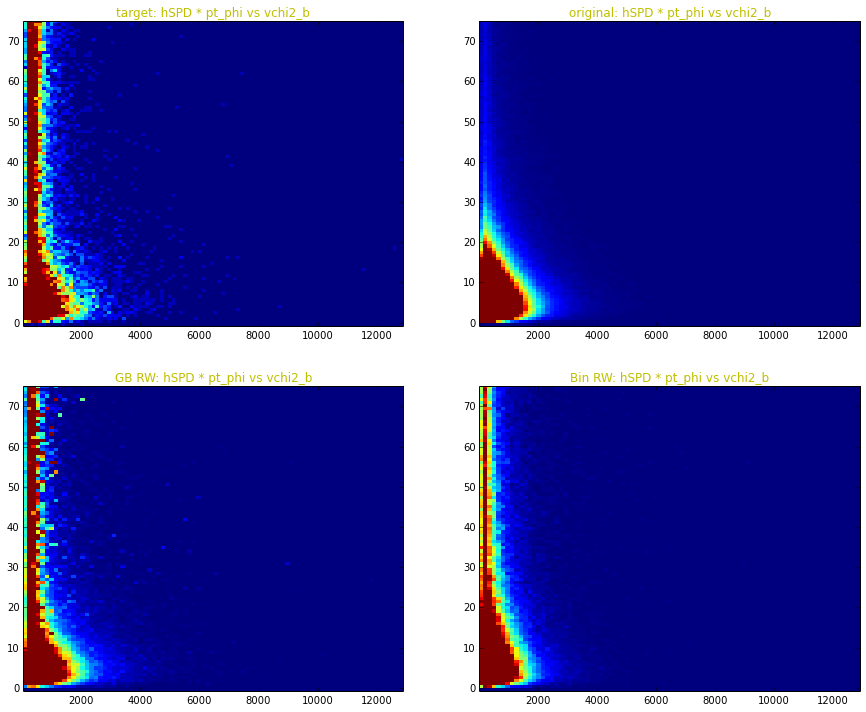

In [20]:
hist2d_expressions('hSPD * pt_phi', 'vchi2_b', 1e-5)

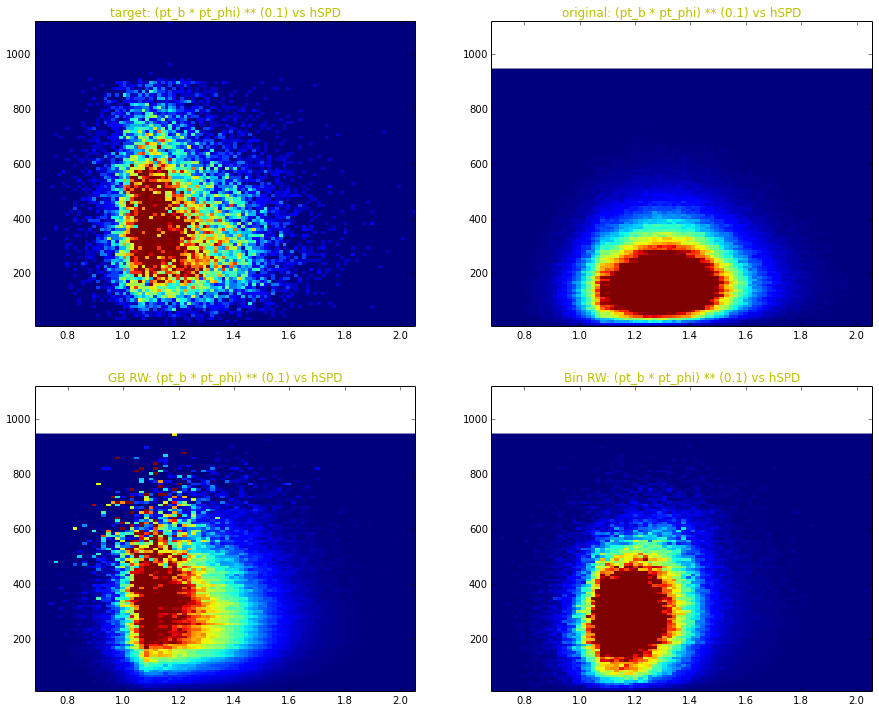

In [21]:
hist2d_expressions('(pt_b * pt_phi) ** (0.1)', 'hSPD', 0.005)

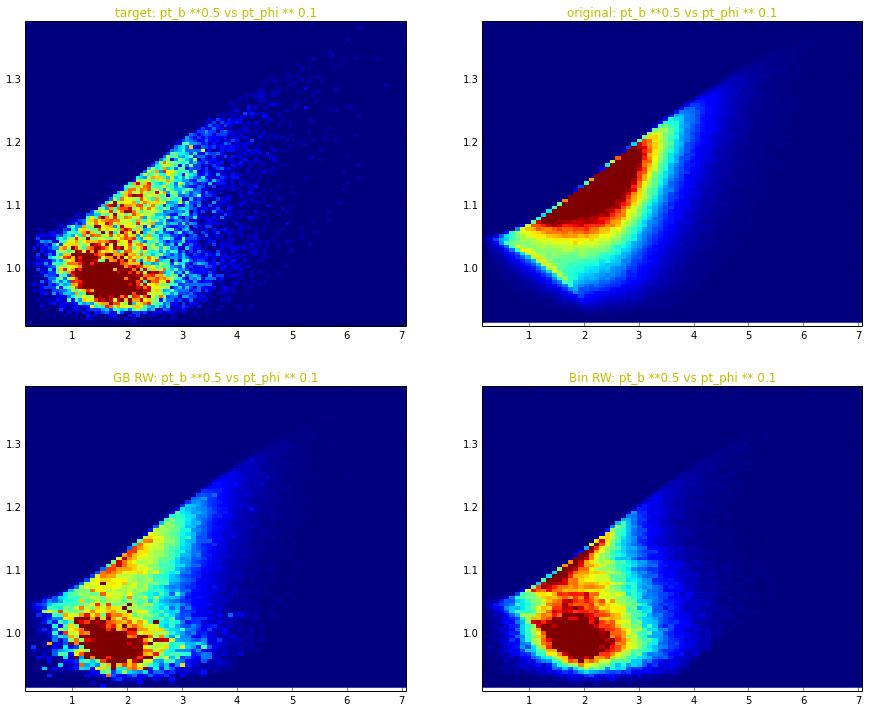

In [22]:
hist2d_expressions('pt_b **0.5', 'pt_phi ** 0.1', 3)

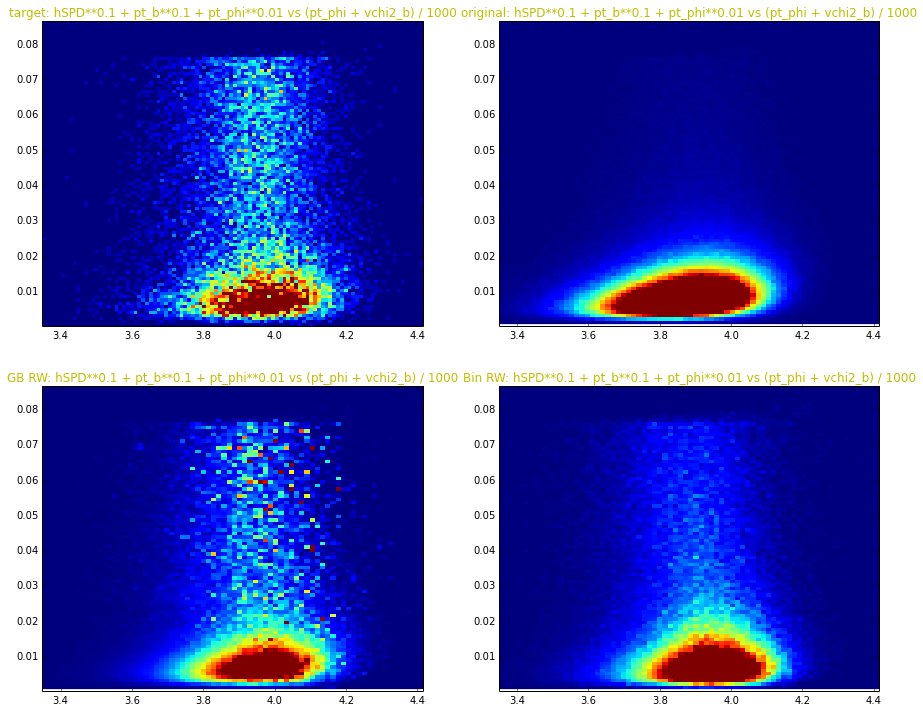

In [23]:
hist2d_expressions('hSPD**0.1 + pt_b**0.1 + pt_phi**0.01', '(pt_phi + vchi2_b) / 1000', 100)

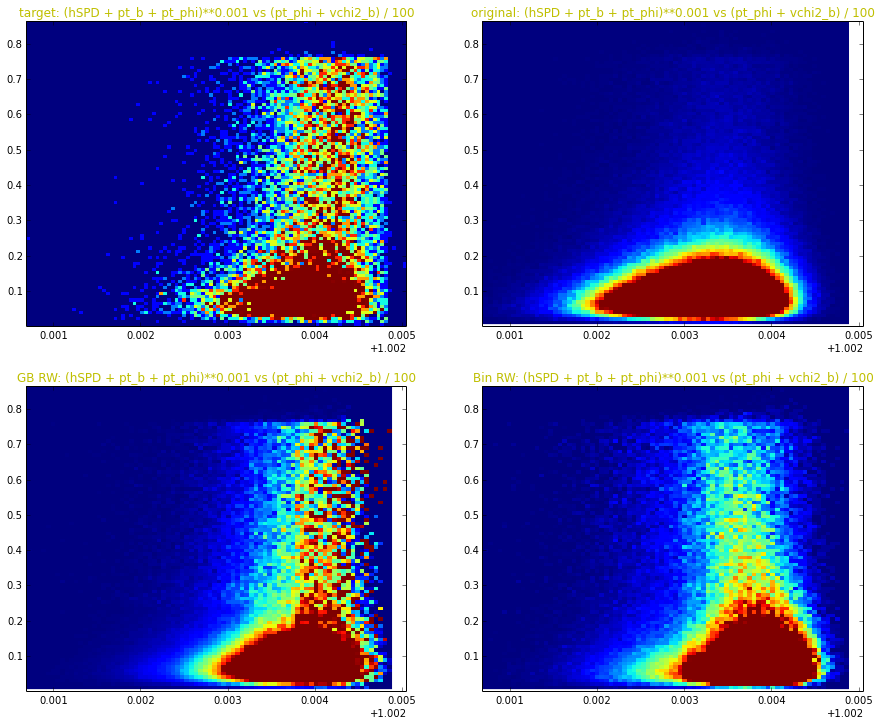

In [24]:
hist2d_expressions('(hSPD + pt_b + pt_phi)**0.001', '(pt_phi + vchi2_b) / 100', 1000)

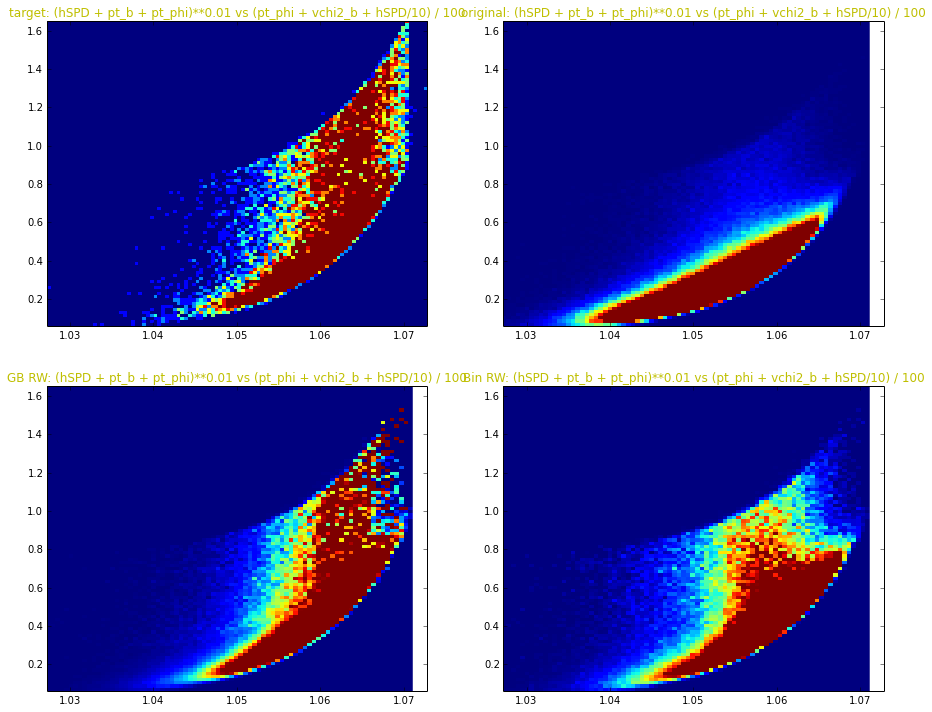

In [25]:
hist2d_expressions('(hSPD + pt_b + pt_phi)**0.01', '(pt_phi + vchi2_b + hSPD/10) / 100', 50)

#### What reweighter is better for feature combinations?

As you can see, GB reweighter is better by its KS for expressions, also for hist2d it looks better and is more similar to the target.

# Build classifier, which agree on MC and real

It is time to apply our knowledge to analyze $\tau\to3\mu$ without only removing disagreement features!

**TODO: **

* analyze $\tau\to3\mu$ data to build classifier which pass agreement threshold 0.09
* compare models trained on disagreement features, without them, with reweigthing (Bin, GB)
* compute AUC and don't forget use weights during the AUC computation if you reweighted data.
* Does reweighting only by one feature `SPDhits` help to pass agreement threshold?
* Compare MC signal vs MC control to avoid systematic error

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [27]:
data = pandas.read_csv('datasets/training.csv')
data_agreement = pandas.read_csv('datasets/check_agreement.csv')
train_features = list(set(data_agreement.columns) - {'id', 'signal', 'weight'})

### Compute KS for all features to find the most disagreement

In [28]:
weights_mc_control = data_agreement[data_agreement.signal == 1]['weight']
weights_rd_control = data_agreement[data_agreement.signal == 0]['weight']

In [29]:
def compute_ks_for_all(features, weights):
    ks_train_features = []
    for feature in features:
        pdf1 = data_agreement.loc[data_agreement.signal == 0, feature].values
        pdf2 = data_agreement.loc[data_agreement.signal == 1, feature].values
        ks_train_features.append(ks_2samp_weighted(pdf1, pdf2, weights1=weights_rd_control, weights2=weights))
    return pandas.DataFrame({'Feature': features, 'KS': ks_train_features}).sort('KS')[::-1]

In [30]:
compute_ks_for_all(train_features, weights_mc_control)

,Feature,KS
2,SPDhits,0.258061
13,FlightDistance,0.107384
23,IP_p1p2,0.095391
43,p2_IP,0.091535
37,p1_IP,0.085189
25,p0_p,0.082562
10,LifeTime,0.082312
9,p0_track_Chi2Dof,0.076330
45,p1_IPSig,0.075248
1,IP,0.073518


The worst features are `SPDhits`, `FlightDistance`, `IP_p1p2`

In [31]:
# Divide train on train, test
train_index, test_index = train_test_split(range(len(data)))
train = data.iloc[train_index, :]
test = data.iloc[test_index, :]

In [32]:
# define function to test model on ks and calculate quality
def test_model(model, features, reweighter=None, reweight_features=None):
    mc_weights = weights_mc_control
    test_weights = numpy.ones(len(test))
    if reweighter is not None:
        mc_weights = reweighter.predict_weights(data_agreement.loc[data_agreement.signal == 1, reweight_features])
        test_weights[test.signal.values == 1] = reweighter.predict_weights(
            test.loc[test.signal == 1, reweight_features])
    probs = model.predict_proba(data_agreement[features])[:, 1]
    pdf1 = probs[data_agreement.signal.values == 0]
    pdf2 = probs[data_agreement.signal.values == 1]
    model_agr = ks_2samp_weighted(pdf1, pdf2, weights1=weights_rd_control, weights2=mc_weights)
    print 'Agreement', model_agr, model_agr < 0.09
    print 'AUC', roc_auc_score(test.signal.values, model.predict_proba(test[features])[:, 1], 
                               sample_weight=test_weights)

### Define GB training with or without reweighter

In [33]:
def compute_ks_between_mc(model, train_features, reweighter, reweight_features):
    pdf1 = model.predict_proba(test.loc[test.signal == 1, train_features].values)[:, 1]
    pdf2 = model.predict_proba(data_agreement.loc[data_agreement.signal == 1, train_features].values)[:, 1]
    weights1 = numpy.ones(len(pdf1))
    weights2 = numpy.ones(len(pdf2))
    
    if reweighter is not None:
        weights1 = reweighter.predict_weights(test.loc[test.signal == 1, reweight_features].values)
        weights2 = reweighter.predict_weights(data_agreement.loc[data_agreement.signal == 1, reweight_features].values)

    print 'MC vs MC KS:', ks_2samp_weighted(pdf1, pdf2, weights1=weights1, weights2=weights2)

In [34]:
def train_gb(train_features, reweighter=None, reweight_features=None):
    gb = GradientBoostingClassifier(n_estimators=200, max_depth=6, 
                                    learning_rate=0.05, min_samples_leaf=50, subsample=0.5, 
                                    max_features=8)
    weights = numpy.ones(len(train))
    if reweighter is not None:
        weights[train.signal.values == 1] = reweighter.predict_weights(train.loc[train.signal == 1, reweight_features])
    gb.fit(train[train_features], train['signal'].values, sample_weight=weights)
    test_model(gb, train_features, reweighter, reweight_features)
    compute_ks_between_mc(gb, train_features, reweighter, reweight_features)

### Simple models

#### Simple model on all features

In [35]:
train_gb(train_features)

Agreement 0.207746062007 False
AUC 0.952959703994
MC vs MC KS: 0.0232861472394


#### Remove disagree features

In [36]:
train_features_agree = list(set(train_features) - {'SPDhits'})

In [37]:
train_gb(train_features_agree)

Agreement 0.0780140284395 True
AUC 0.94312613771
MC vs MC KS: 0.0146527014478


### Reweighters for several features

#### define target and original pdfs for reweighters

In [38]:
target = data_agreement[data_agreement.signal == 0]
original = data_agreement[data_agreement.signal == 1]
reweight_features = ['SPDhits', 'FlightDistance', 'IP_p1p2']

#### Bin Reweighter

SPDhits KS: 0.145040726779
FlightDistance KS: 0.0356988625715
IP_p1p2 KS: 0.0411128913387


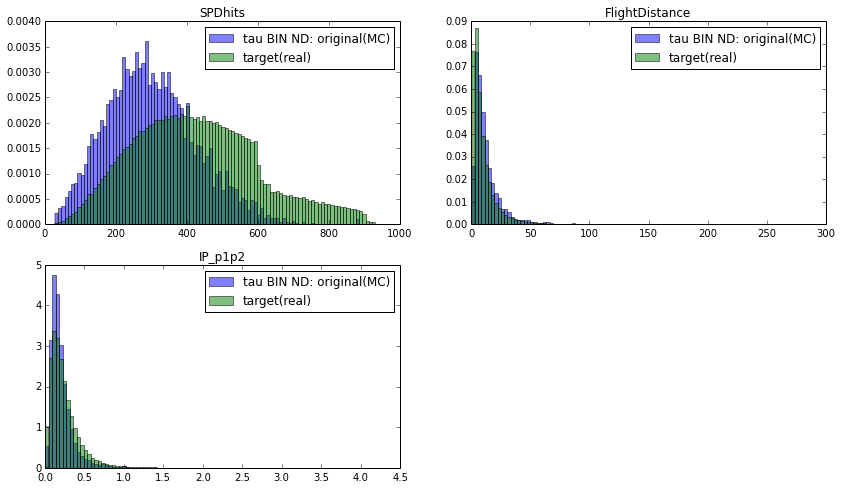

In [39]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original[reweight_features], target[reweight_features], target_weight=weights_rd_control)
bins_weights = bins_reweighter.predict_weights(original[reweight_features])
plot_pdf(reweight_features, bins_weights, label='tau BIN ND: ', weights_target=weights_rd_control)

In [40]:
compute_ks_for_all(train_features, bins_weights)

,Feature,KS
2,SPDhits,0.145041
31,CDF3,0.077519
33,p0_pt,0.066826
9,p0_track_Chi2Dof,0.062719
25,p0_p,0.059658
11,IPSig,0.052825
45,p1_IPSig,0.052714
1,IP,0.052219
3,p2_IPSig,0.052015
43,p2_IP,0.048445


In [41]:
train_gb(train_features, bins_reweighter, reweight_features)

Agreement 0.110145906771 False
AUC 0.942734030732
MC vs MC KS: 0.0330374003776


#### GB Reweighter

SPDhits KS: 0.0224152441445
FlightDistance KS: 0.00872426257389
IP_p1p2 KS: 0.00832193286147


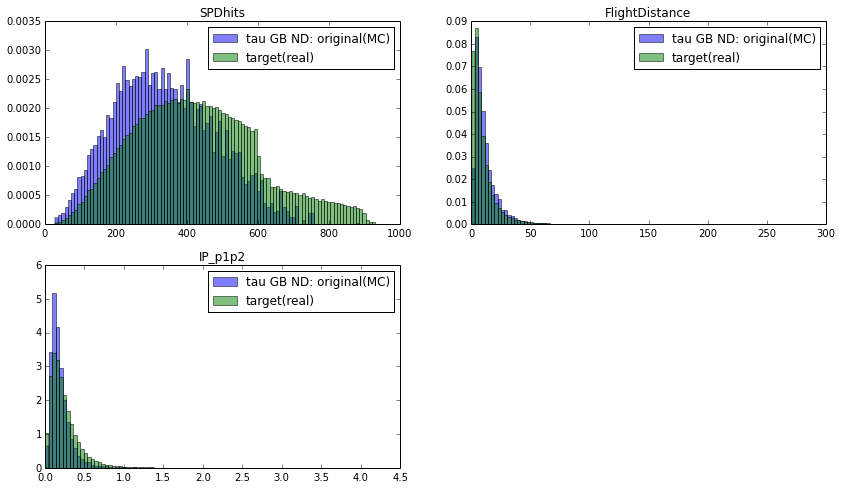

In [42]:
reweighter = reweight.GBReweighter(n_estimators=100, learning_rate=0.3, max_depth=5, min_samples_leaf=500, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(original[reweight_features], target[reweight_features], target_weight=weights_rd_control)
gb_weights = reweighter.predict_weights(original[reweight_features])
plot_pdf(reweight_features, gb_weights, label='tau GB ND: ', weights_target=weights_rd_control)

In [43]:
compute_ks_for_all(train_features, gb_weights)

,Feature,KS
31,CDF3,0.140665
26,isolationa,0.082484
14,p0_IsoBDT,0.067233
24,isolationb,0.062353
33,p0_pt,0.058265
34,ISO_SumBDT,0.057106
16,p2_IsoBDT,0.055818
9,p0_track_Chi2Dof,0.054136
19,isolationc,0.051550
3,p2_IPSig,0.051024


In [44]:
train_gb(train_features, reweighter, reweight_features)

Agreement 0.115308097277 False
AUC 0.977735083245
MC vs MC KS: 0.581272513822


### Reweight only on `SPDhits`

In [45]:
reweight_features = ['SPDhits']

SPDhits KS: 0.0154902176843


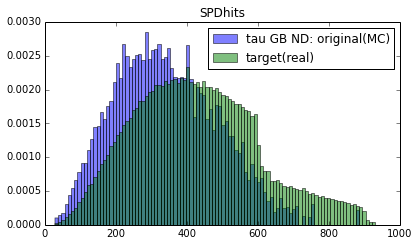

In [46]:
reweighter = reweight.GBReweighter(n_estimators=100, learning_rate=0.3, max_depth=5, min_samples_leaf=500, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(original[reweight_features], target[reweight_features], target_weight=weights_rd_control)
gb_weights = reweighter.predict_weights(original[reweight_features])
plot_pdf(reweight_features, gb_weights, label='tau GB ND: ', weights_target=weights_rd_control)

In [47]:
compute_ks_for_all(train_features, gb_weights)

,Feature,KS
31,CDF3,0.138731
13,FlightDistance,0.112120
43,p2_IP,0.096392
23,IP_p1p2,0.095875
25,p0_p,0.090829
3,p2_IPSig,0.082942
37,p1_IP,0.081525
10,LifeTime,0.078831
1,IP,0.077710
45,p1_IPSig,0.075298


In [48]:
train_gb(train_features, reweighter, reweight_features)

Agreement 0.099123171859 False
AUC 0.941762642812
MC vs MC KS: 0.0273515731806


# Iterative learning

Try apply iterative learning scheme on $\tau\to3\mu$. Does it help to improve quality?

In [49]:
variables_1 = ['isolationa', 'isolationb', 'isolationc', 'SPDhits', 'p0_track_Chi2Dof',
              'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_eta', 'p1_eta', 'p2_eta',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig']

In [50]:
variables_2 = list(set(train.columns) - {'mass', 'signal', 'production', 'min_ANNmuon'} - set(variables_1))

## Simple model

In [57]:
gb = GradientBoostingClassifier(n_estimators=400, max_depth=7, 
                                learning_rate=0.01, min_samples_leaf=50, subsample=0.7, 
                                max_features=8)
gb.fit(train[variables_2], train['signal'].values)
test_model(gb, variables_2)
compute_ks_between_mc(gb, variables_2, None, None)

Agreement 0.0454228203983 True
AUC 0.924251811233
MC vs MC KS: 0.053662976688


## Iterative 

In [58]:
from rep.metaml import FoldingClassifier

#### First stage

In [59]:
baseline = GradientBoostingClassifier(n_estimators=400, max_depth=7, 
                                      learning_rate=0.01, min_samples_leaf=50, subsample=0.7, 
                                      max_features=8)

folding1 = FoldingClassifier(baseline, features=variables_1)
folding1.fit(train, train['signal'])

FoldingClassifier(base_estimator=GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=7, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              random_state=None, subsample=0.7, verbose=0,
              warm_start=False),
         features=['isolationa', 'isolationb', 'isolationc', 'SPDhits', 'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_eta', 'p1_eta', 'p2_eta', 'p0_IPSig', 'p1_IPSig', 'p2_IPSig'],
         ipc_profile=None, n_folds=2, random_state=None)

In [61]:
p_ks = folding1.predict_proba(data_agreement)[:, 1]

KFold prediction using random classifier (length of data passed not equal to length of train)


#### Reweight predictions on the contol channel

In [62]:
rew = reweight.GBReweighter(n_estimators=50, max_depth=2, learning_rate=0.008)
rew.fit(p_ks[data_agreement.signal.values == 1],
        p_ks[data_agreement.signal.values == 0], 
        original_weight=data_agreement[data_agreement.signal == 1]['weight'].values,
        target_weight=data_agreement[data_agreement.signal == 0]['weight'].values)

GBReweighter(gb_args={}, learning_rate=0.008, max_depth=2,
       min_samples_leaf=200, n_estimators=50)

In [63]:
weights1 = rew.predict_weights(p_ks[data_agreement.signal.values == 1],
                               data_agreement[data_agreement.signal == 1]['weight'].values)

In [64]:
ks_2samp_weighted(p_ks[data_agreement.signal.values == 0],
                  p_ks[data_agreement.signal.values == 1],
                  data_agreement[data_agreement.signal == 0]['weight'].values,
                  weights1)

0.16697807925679214

In [65]:
p1_train = folding1.predict_proba(train)[:, 1]

KFold prediction using folds column


In [66]:
train_weights = rew.predict_weights(p1_train[train.signal.values == 1], [1] * numpy.sum(train.signal == 1))

#### Use predictions as feature, use weights

In [67]:
train['new'] = p1_train
baseline = GradientBoostingClassifier(n_estimators=400, max_depth=7, 
                                      learning_rate=0.01, min_samples_leaf=50, subsample=0.7, 
                                      max_features=8)
varibales_all = variables_2 + ['new']
weights_all = numpy.ones(len(train))
weights_all[train.signal.values == 1] = rew.predict_weights(p1_train[train.signal.values == 1])
baseline.fit(train[varibales_all], train['signal'], sample_weight=weights_all)

/Users/antares/.virtualenvs/test/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=7, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              random_state=None, subsample=0.7, verbose=0,
              warm_start=False)

In [68]:
test['new'] = folding1.predict_proba(test)[:, 1]
data_agreement['new'] = folding1.predict_proba(data_agreement)[:, 1]

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


/Users/antares/.virtualenvs/test/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [69]:
test_model(baseline, varibales_all, rew, ['new'])
compute_ks_between_mc(baseline, varibales_all, None, None)

Agreement 0.0957052868658 False
AUC 0.940837492817
MC vs MC KS: 0.0246571446804
